<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1">Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2">Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3">Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4">Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок. Конечный результат — модель со значением метрики качества *F1* не меньше 0.75. 

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

**План работы над задачей:**

1) **Подготовка** — изучим данные на предмет возникновения в них аномалий, пропусков и ошибок. В случае нахождения — обработаем их. 

2) **Обучение моделей** — обучим модели LinearRegression и DecisionTreeClassifier, определим их лучшие гиперпараметры и показатели метрики f1.

3) Сделаем **итоговый вывод** об основных итогах исследования и предложим заказчику лучшую модель.

In [1]:
import pandas as pd
import numpy as np
import nltk
import re
import os

from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk import pos_tag
from tqdm.notebook import tqdm

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import rcParams, rcParamsDefault
rcParams['figure.figsize'] = 10, 6
%config InlineBackend.figure_format = 'svg'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

def plot_describe (t, x_l, y_l): # Заранее пропишем функцию, подписывающую название графика и осей
    plt.title(t)                 # Здесь параметр t будет отвечать за название графика  
    plt.xlabel(x_l)              # Параметр x_l — за подпись горизонтальной оси
    plt.ylabel(y_l)              # Параметр y_l — за подпись вертикальной оси
    plt.show()

TEST_SIZE = 0.25
RANDOM_STATE = 42

## Подготовка

In [2]:
pth1 = 'C:/pr/datasets/toxic_comments.csv' # Считаем csv-файл
pth2 = '/datasets/toxic_comments.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1, index_col=0)
elif os.path.exists(pth2):
    data = pd.read_csv(pth2, index_col=0)
else:
    print('Something is wrong')

Изучим общую информацию о датасете. Однако, прежде чем мы приступим к её разбору, напишем **вспомогательную функцию**. Так проводить анализ будет быстрее и удобнее:

In [3]:
def describe_data (data):
    print('Первые пять строк таблицы:')
    display(data.head())
    print('\n', 'Последние пять строк таблицы:')
    display(data.tail())
    print('\n', 'Общая информация о датасете:', '\n')
    data.info()
    print('\n', 'Описательные статистики датасета:')
    display(data.describe().round(2))
    print('\n', 'Количество пропусков в данных:')
    display(data.isna().sum())

In [4]:
describe_data(data) # Изучаем данные о датасете

Первые пять строк таблицы:


,text,toxic
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0



 Последние пять строк таблицы:


,text,toxic
159446,""":::::And for the second time of asking, when your view completely contradicts the coverage in reliable sources, why should anyone care what you feel? You can't even give a consistent argument - is the opening only supposed to mention significant aspects, or the """"most significant"""" ones? \n\n""",0
159447,You should be ashamed of yourself \n\nThat is a horrible thing you put on my talk page. 128.61.19.93,0
159448,"Spitzer \n\nUmm, theres no actual article for prostitution ring. - Crunch Captain.",0
159449,And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.,0
159450,"""\nAnd ... I really don't think you understand. I came here and my idea was bad right away. What kind of community goes """"you have bad ideas"""" go away, instead of helping rewrite them. """,0



 Общая информация о датасете: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB

 Описательные статистики датасета:


,toxic
count,159292.0
mean,0.1
std,0.3
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,1.0



 Количество пропусков в данных:


text     0
toxic    0
dtype: int64

In [5]:
data.duplicated().sum() # Находим количество очевидных дубликатов

0

In [6]:
data['toxic'].unique()

array([0, 1])

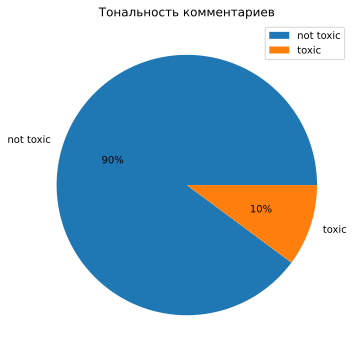

In [7]:
data['toxic'].value_counts().plot(y='count', kind='pie',
    labels=['not toxic', 'toxic'], autopct='%1.0f%%', legend = True)
plot_describe('Тональность комментариев', '' , '')

Выбросов и дубликатов в данных не обнаружено, однако есть заметный дисбаланс классов целевого признака. Учтём это в дальнейшем при обучении моделей.

Выполним лемматизацию текста и удаление ненужных символов:

In [8]:
corpus = data['text'].values

In [9]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [10]:
def get_wordnet_pos(word): 
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize(text):
    m = WordNetLemmatizer()
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\']', ' ', text)
    text = text.split()
    return ' '.join([m.lemmatize(i, get_wordnet_pos(i)) for i in text])

tqdm.pandas()
data['new_text'] = data['text'].progress_apply(lemmatize)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [11]:
data.head()

,text,toxic,new_text
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,explanation why the edits make under my username hardcore metallica fan be revert they weren't vandalism just closure on some gas after i vote at new york doll fac and please don't remove the template from the talk page since i'm retire now
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,d'aww he match this background colour i'm seemingly stuck with thanks talk january utc
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,hey man i'm really not try to edit war it's just that this guy be constantly remove relevant information and talk to me through edits instead of my talk page he seem to care more about the format than the actual info
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,more i can't make any real suggestion on improvement i wonder if the section statistic should be later on or a subsection of type of accident i think the reference may need tidy so that they be all in the exact same format ie date format etc i can do that later on if no one else do first if you have any preference for format style on reference or want to do it yourself please let me know there appear to be a backlog on article for review so i guess there may be a delay until a reviewer turn up it's list in the relevant form eg wikipedia good article nomination transport
4,"You, sir, are my hero. Any chance you remember what page that's on?",0,you sir be my hero any chance you remember what page that's on


In [12]:
data.duplicated().sum() # Проверяем, не появилось ли новых дубликатов

0

**Промежуточный вывод:**

Выбросов и дубликатов в данных не обнаружено, однако есть заметный дисбаланс классов целевого признака. Учтём это в дальнейшем при обучении моделей.

Проведена подготовка данных к дальнейшей работе за счёт лемматизации текста, удаления ненужных символов и очистки от регулярных выражений. 

## Обучение

In [13]:
X = data.drop(['toxic', 'text'], axis = 1) 
y = data['toxic']

X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y,
        test_size = TEST_SIZE,
        random_state=RANDOM_STATE
    ) 

stop_words = set(stopwords.words('english'))

In [14]:
X_train_l = list(X_train['new_text']) # Выполним трансформацию текстов в векторы при помощи tf-idf
X_test_l = list(X_test['new_text'])

In [15]:
params_lr = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['liblinear', 'saga']
}

pipeline_lr = Pipeline(
    [
        ('vect', TfidfVectorizer(stop_words=stop_words)),
        ('classifier', LogisticRegression())
]
)

search_lr = RandomizedSearchCV(
    estimator=pipeline_lr,
    param_distributions=params_lr,
    n_iter=10,
    scoring=make_scorer(f1_score, average='binary'),
    cv=5,
    random_state=RANDOM_STATE
)

search_lr.fit(X_train_l, y_train)

print("Best parameters:", search_lr.best_params_)
print("Best F1 score:", search_lr.best_score_)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not 

Best parameters: {'classifier__solver': 'saga', 'classifier__C': 10}
Best F1 score: 0.7688494326854635


Обучим две модели — логистическую регрессию с двумя типами регуляризации и DecisionTreeClassifier — и переберём их гиперпараметры, чтобы найти наилучшие: 

In [16]:
params_dt = {
    'classifier__max_depth': [4, 6, 8]
}

pipeline_dt = Pipeline(
    [
        ('vect', TfidfVectorizer(stop_words)),
        ('classifier', DecisionTreeClassifier())
]
)

search_dt = RandomizedSearchCV(
    estimator=pipeline_dt,
    param_distributions=params_dt,
    n_iter=10,
    scoring=make_scorer(f1_score, average='binary'),
    cv=5,
    random_state=RANDOM_STATE
)

search_dt.fit(X_train_l, y_train)

print("Best parameters:", search_dt.best_params_)
print("Best F1 score:", search_dt.best_score_)

/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass input={'m', 'for', 'not', 'here', 'been', 'wouldn', 'themselves', 'just', "shouldn't", "won't", 'them', 'under', 'during', "didn't", "hasn't", "needn't", 'their', 'each', 'off', 'were', 'to', "couldn't", 'theirs', 'did', 'about', 'whom', 'why', 'didn', 'than', 'out', 'the', 'those', 'because', 'this', 'same', "you'd", 'that', 'both', 'and', 'my', 'in', 'needn', 'nor', "haven't", 'very', "mustn't", 'his', "wouldn't", 'through', 're', 'y', 'only', 'myself', "don't", 'he', 'on', 'so', "it's", 'with', 'ours', 'himself', 'haven', 'aren', 'being', "weren't", 'was', 'you', 'there', 'herself', "wasn't", 'are', 'doing', 'i', 'who', "you're", 'these', 've', 'couldn', "hadn't", 'which', 'will', 'having', 'is', 'be', 'mightn', "you'll", 'more', 'shan', 'yours', 'until', 'our', 'mustn', 'do', "aren't", "you've", 'ain', 's', 'don', 'when', 'as', 'itself', 'won', 'weren', 'o', 'she', 'too', 'yourself', 'your', 

Best parameters: {'classifier__max_depth': 8}
Best F1 score: 0.5902411138016588


Лучшей из рассмотренных моделей оказалась логистическая регрессия с l1-регуляризацией и параметром регуляризации *C* равным четырём, поэтому предсказание будем делать на основе неё:

In [17]:
preds = search_lr.predict(X_test_l)
print(f1_score(y_test, preds, average='binary').round(2))

0.77


Также проверим модель на адекватность при помощи `DummyClassifier`:

In [18]:
dummy_model = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
dummy_model.fit(X_train, y_train)
dummy_model_preds = dummy_model.predict(X_test)
f1_dummy = f1_score(y_test, dummy_model_preds, average='binary')
print(f"Dummy Classifier F1-score: {f1_dummy:.2f}")

Dummy Classifier F1-score: 0.00


## Выводы

В качестве финальной модели для тестирования была выбрана модель логистической регрессии с алгоритмом оптимизации *saga* и параметром регуляризации *C* равным десяти. Достигнутый показатель метрики f1 на тестовых данных равен 0.77, что удовлетворяет заявленному заказчиком порогу в 0.75.

На этапе **подготовки** в данных не было обнаружено выбросов и дубликатов, однако был заметен дисбаланс классов целевого признака, что было учтено при обучении моделей. Также была проведена подготовка данных к дальнейшей работе за счёт лемматизации текста, удаления ненужных символов и очистки от регулярных выражений.

**Обучение моделей** и перебор их гиперпараметров позволили выявить лучшую модель — ей оказалась модель логистической регрессии, показавшая на тренировочной выборке значение метрики f1 = 0.77.